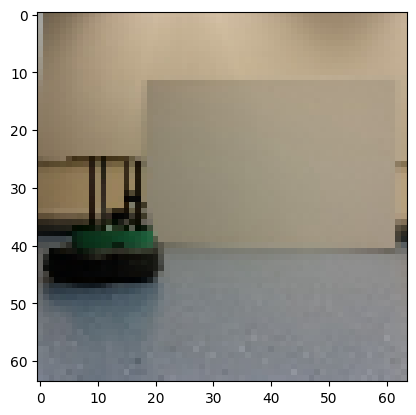

In [6]:

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2

import segment as seg
# Read in the image
image = cv2.imread('imgs/photos/record-3.png')
open_cv_image = np.array(image)
resized_image = np.array(cv2.resize(image, (64,64)))
image=np.array(resized_image)/255.0

plt.imshow(image)

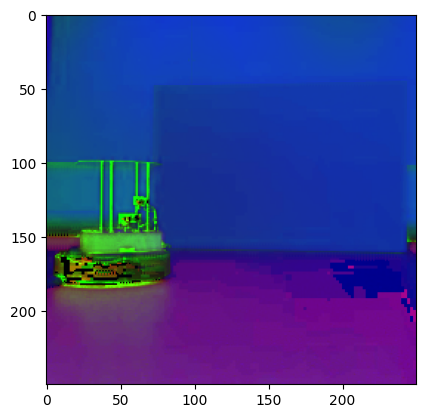

In [7]:
# Prepration

image_hsv = cv2.cvtColor(open_cv_image, cv2.COLOR_RGB2HSV)

plt.imshow(image_hsv)

[[[  1 215 153]]

 [[ 71 154 131]]

 [[ 99  10 173]]

 [[ 20  60 208]]

 [[  0   0   0]]]


Text(0.5, 0, 'V')

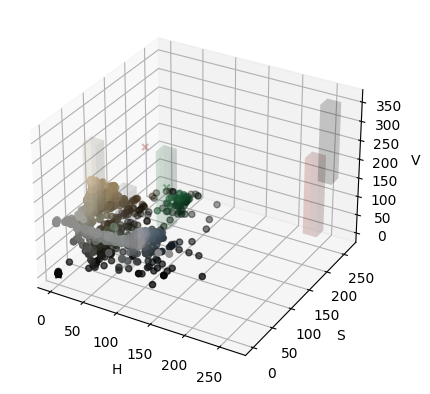

In [23]:
# 3d plot
thresholds = [10,10,100]


small_hsv = cv2.resize(open_cv_image, (64,64))
small_hsv = cv2.cvtColor(small_hsv, cv2.COLOR_RGB2HSV)

features_hsv = cv2.cvtColor(seg.features.reshape(5,1,3), cv2.COLOR_RGB2HSV)
print(features_hsv)
ax = plt.figure().add_subplot(projection='3d')
ax.scatter(small_hsv[:,:,0].reshape(-1),small_hsv[:,:,1].reshape(-1),small_hsv[:,:,2].reshape(-1),c=image.reshape(-1,3),marker='o')

ax.scatter(features_hsv[:,:,0].reshape(-1),features_hsv[:,:,1].reshape(-1),features_hsv[:,:,2].reshape(-1),c=seg.features/255.0,marker='x')
ax.bar3d(features_hsv[:,:,0].reshape(-1) - thresholds[0],features_hsv[:,:,1].reshape(-1) - thresholds[1],features_hsv[:,:,2].reshape(-1) - thresholds[2],thresholds[0]*2,thresholds[1]*2,thresholds[2]*2,color=seg.features/255.0,alpha=0.1)

ax.set_xlabel('H')
ax.set_ylabel('S')
ax.set_zlabel('V')

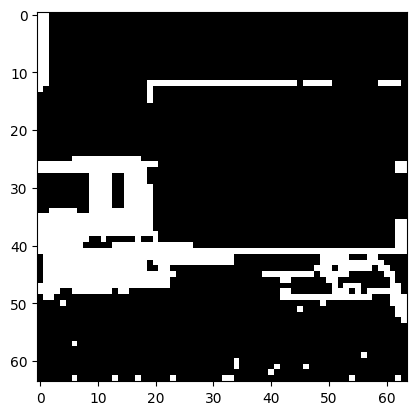

In [9]:
edges = seg.compute_edges(cv2.cvtColor(open_cv_image,cv2.COLOR_RGB2HSV)/255.0)
edges = cv2.resize(edges, (64,64),interpolation=cv2.INTER_NEAREST)
plt.imshow(edges,cmap='gray')


In [11]:
# Find the nearest point in the feature space
#
def find_nearest(array, value):
    #print(array.shape)
    dist = np.linalg.norm(array - value, axis=1)
    idx = dist.argmin()
    if (dist[idx] > 20):
        return np.array([0,0,0]), -1
    
    #print(array[idx].shape)
    return array[idx], idx

vectorized_find_nearest = np.vectorize(find_nearest, excluded=['array'], signature='(n,m),(m)->(m),()')
img = small_hsv.copy()

features_hsv = seg.features.reshape(5,1,3) #, cv2.COLOR_RGB2HSV)

nearest,idx = vectorized_find_nearest(features_hsv.reshape(-1,3), img.reshape(-1,3))
nearest = nearest.reshape(64,64,3)
idx = idx.reshape(64,64)

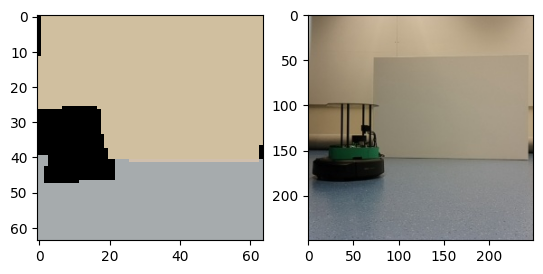

In [13]:
import importlib
importlib.reload(seg)

result_img = open_cv_image.copy()

s = seg.segment(result_img)
#s = seg.compute_edges(result_img/255.0)

plt.subplot(1,2,1)
plt.imshow(s[-1],cmap='gray')
plt.subplot(1,2,2)
plt.imshow(result_img)

In [24]:
features = seg.features

def segment3(img):
    edges = seg.compute_edges(img/255.0)
    flood_filled = cv2.resize(img, (64,64))

    flood_filled = flood_filled * (edges == 0)[:,:,np.newaxis]

    flood_filled, mask,range_img = flood_fill2(cv2.cvtColor(flood_filled,cv2.COLOR_RGB2HSV),cv2.cvtColor(features.reshape(1,5,3),cv2.COLOR_RGB2HSV).reshape(5,3),thresholds)

    flood_filled = cv2.dilate(flood_filled, np.ones((3,3),np.uint8), iterations=1)

    return flood_filled, mask ,edges,range_img

def segment2(img):
    edges = seg.compute_edges(img/255.0)
    flood_filled = cv2.resize(img, (64,64))

    flood_filled = flood_filled * (edges == 0)[:,:,np.newaxis]

    flood_filled, mask,range_img = flood_fill2(flood_filled)

    flood_filled = cv2.dilate(flood_filled, np.ones((3,3),np.uint8), iterations=1)

    return flood_filled, mask ,edges,range_img

thresholds = [10,10,10]

def flood_fill2(img,_features,_thresholds):
    mask = np.zeros((64+2,64+2),np.uint8)
    range_img = np.zeros((64,64,3),np.uint8)
    for i in range(0,len(_features)):
        low = (_features[i] - thresholds)
        high = (_features[i] + thresholds)
        in_range = cv2.inRange(img, low, high) >= 1
        range_img[in_range] = _features[i]
        arr = np.argwhere(in_range)
        
        if (len(arr) == 0):
            continue

        for j in range(0,len(arr)):
            rgb = (int(_features[i,0]),int(_features[i,1]),int(_features[i,2]))
            _,img,mask,_ = cv2.floodFill(img, mask, (arr[j,1],arr[j,0]), rgb,loDiff=thresholds,upDiff=thresholds)

    #img = img * (mask[1:-1,1:-1] == 1)[:,:,np.newaxis]

    return img, mask,range_img



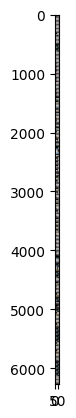

In [31]:
import glob 

files = glob.glob('imgs/recordings/*.png')[:-1]


big_img = np.zeros((1,64,3),np.uint8)
for file in files:
    img = cv2.imread(file)
    result,mask, edge,range_img = segment3(img)

    result =  cv2.cvtColor(result,cv2.COLOR_HSV2RGB)

    big_img = np.concatenate((big_img,result),axis=0)

plt.imshow(big_img)


    #plt.figure()

    #plt.subplot(1,5,1)
    #plt.imshow(img)
    #plt.subplot(1,5,2)
    #plt.imshow(result)
    #plt.subplot(1,5,3)
    #plt.imshow(edge,cmap='gray')
    #plt.subplot(1,5,4)
    #plt.imshow(mask,cmap='gray')
    #plt.subplot(1,5,4)
    #plt.imshow(range_img)
